# INTRO

This project explores the application of deep learning for image captioning , using transformer-based architectures to generate descriptive captions from images. The Flickr8k dataset , containing 8,000 images each paired with five descriptive captions, is used for training and evaluation. The goal is to implement and analyze attention-based models, focusing on how different hyperparameters affect performance in generating accurate and meaningful image descriptions.

# Data Overview

> Below is a brief overview and summary statistics of the data.

> https://www.kaggle.com/datasets/adityajn105/flickr8k

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,TimeDistributed, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import re

2025-05-11 07:35:58.695090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746948958.878315      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746948958.926496      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Data & Show Samples

In [2]:
# Set paths
image_path = '/kaggle/input/flickr8k/Images'
df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')

In [3]:
# Function to load and preprocess image
def read_image(path, img_size=224):
    try:
        img = load_img(path, target_size=(img_size, img_size))
        img_array = img_to_array(img) / 255.0  # Normalize
        return img_array
    except Exception as e:
        print(f"Error loading image from {path}: {e}")
        return None


def display_images(temp_df, image_dir=image_path, rows=5, cols=5, img_size=224):
    total_images = rows * cols
    temp_df = temp_df.head(total_images).reset_index(drop=True)

    # Set style and figure
    sns.set_style("white")
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3.5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= len(temp_df):
            ax.axis('off')
            continue

        img_path = os.path.join(image_dir, temp_df.iloc[i]['image'])
        image = read_image(img_path, img_size=img_size)

        if image is not None:
            # Show image with better interpolation
            ax.imshow(image, interpolation='bilinear')
            caption = "\n".join(wrap(temp_df.iloc[i]['caption'], 25))

            # Styled title inside box
            ax.set_title(f"\n{caption}",
                         fontsize=11,
                         bbox=dict(facecolor='#1f1f1f', alpha=0.85, edgecolor='none', boxstyle="round,pad=0.4"),
                         color='white',
                         wrap=True,
                         pad=10)
            ax.axis('off')

            # Optional: Add a subtle border around the image
            for spine in ax.spines.values():
                spine.set_edgecolor('#dddddd')
                spine.set_linewidth(1.2)
        else:
            ax.text(0.5, 0.5, "Image Not Found", ha='center', va='center', fontsize=12, color='darkred')
            ax.axis('off')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=1.5)
    plt.show()

### Display sample images

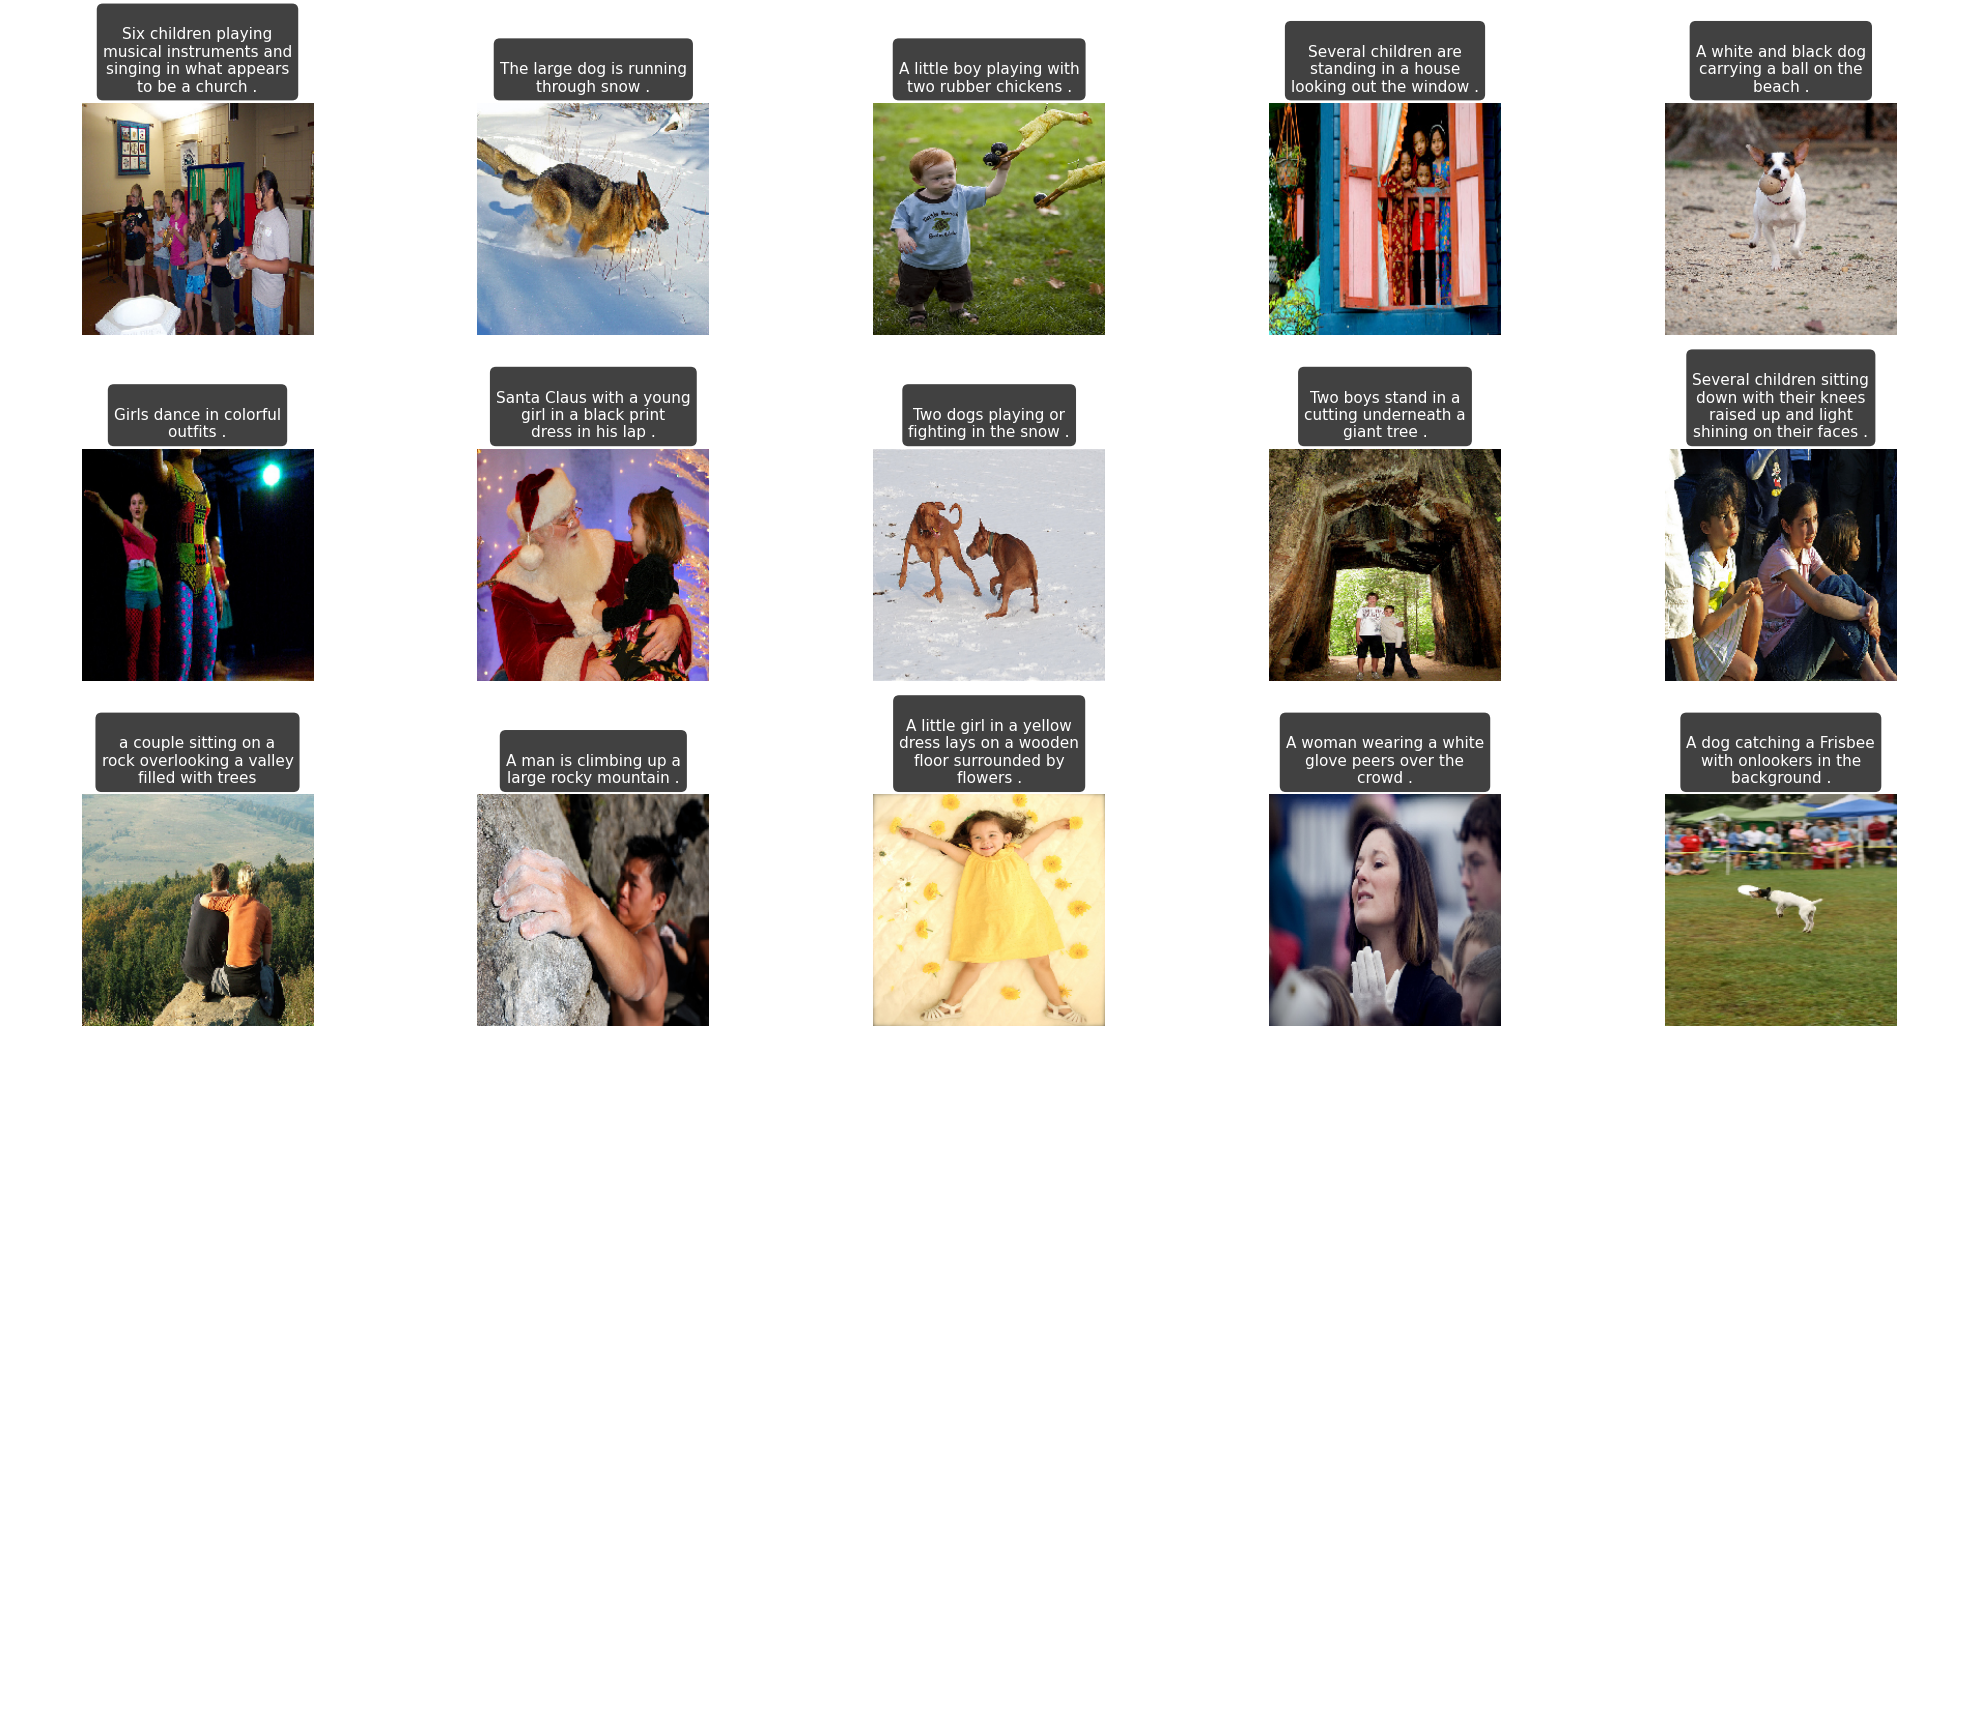

In [4]:
display_images(df.sample(15))

# Data Preprocessing

### Caption Text Preprocessong

In [5]:
def text_preprocessing(data, caption_col='caption'):  
    def clean_caption(text):
        text = re.sub(r'\b(startseq|endseq)\b', '', text).strip()
        text = text.lower()
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        words = [w for w in text.split() if len(w) > 1 or w in ['a', 'i']]
        text = ' '.join(words)
        return f'startseq {text} endseq'
    
    # Apply cleaning function
    data[caption_col] = data[caption_col].apply(clean_caption)
    
    return data

In [6]:
df = text_preprocessing(df)
captions = df['caption'].tolist()
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenization and Encoded

In [7]:
df['caption'] = df['caption'].astype(str).str.strip()
df = df[df['caption'].str.split().str.len() > 1].reset_index(drop=True)  # Keep only captions with at least two words

tokenizer = Tokenizer(
    num_words=None,                             # Keep all words
    filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',  # Default filters
    lower=True,
    split=' ',
    oov_token="<OOV>"                           # Optional: add Out-of-Vocabulary token
)

# Fit on cleaned captions
tokenizer.fit_on_texts(df['caption'])

# Get vocab size (+1 for padding token)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size (with <OOV>): {vocab_size}")

caption_lengths = df['caption'].apply(lambda x: len(x.split()))
max_length = caption_lengths.max()
print(f"Maximum Caption Length: {max_length}")
unique_images = df['image'].unique()

# Stratified or random split
train_images, val_images = train_test_split(
    unique_images,
    test_size=0.15,
    random_state=42,
    shuffle=True
)

# Create train/test DataFrames
train = df[df['image'].isin(train_images)].reset_index(drop=True)
test = df[df['image'].isin(val_images)].reset_index(drop=True)

print(f"Train samples: {len(train)}, Validation samples: {len(val_images)}")

example_caption = captions[1]
tokenized = tokenizer.texts_to_sequences([example_caption])
padded = pad_sequences(tokenized, maxlen=max_length, padding='post', truncating='post')

Vocabulary Size (with <OOV>): 8771
Maximum Caption Length: 37
Train samples: 34385, Validation samples: 1214


In [8]:
print("\nExample Caption:")
print("Original: ", example_caption)
print("Tokenized: ", tokenized)
print("Padded:   ", padded)


Example Caption:
Original:  startseq a girl going into a wooden building endseq
Tokenized:  [[3, 2, 20, 314, 65, 2, 194, 118, 4]]
Padded:    [[  3   2  20 314  65   2 194 118   4   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


# Image Feature Extraction 

## Using CNN Pretrained Model 

In [9]:
# Use a pretrained CNN model for feature extraction
model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg')

img_size = 600
features = {}

# Loop through each unique image
for image in tqdm(df['image'].unique().tolist()):
    # Load and preprocess the image
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = preprocess_input(img)  # Use EfficientNet's preprocessing
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Extract features using the model directly
    feature = model.predict(img, verbose=0)  
    features[image] = feature[0]                     # Save flattened feature vector

I0000 00:00:1746948976.678289      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746948994.147657      95 service.cc:148] XLA service 0x78c82c073bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746948994.148722      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746948996.308714      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746949002.827683      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [16:40<00:00,  8.08it/s]


## EfficientNetB7 Representation
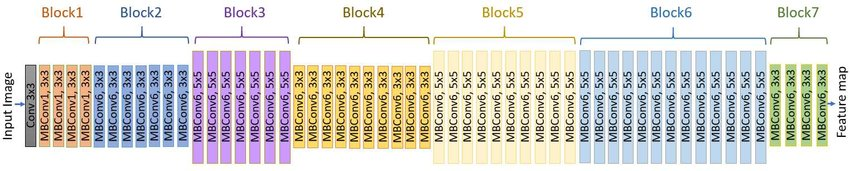

- EfficientNetB7 process image though all convolution blocks and at the end applies Global Average Pooling , and output shape (1, 2560) → meaning 2560 features extracted from the image.

# LSTM Modeling

### Images and Text

In [10]:
# Inputs
image_input = Input(shape=(2560,), name='image_features')         # CNN output (EfficientNet)
caption_input = Input(shape=(max_length,), name='caption_input')  # Tokenized caption input

# Image feature embedding
img_embedding = Dense(256, activation='relu', name='image_dense')(image_input)
img_reshaped = Reshape((1, 256), name='reshape_image')(img_embedding)

# Caption feature embedding
caption_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False, name='caption_embedding')(caption_input)

# Combine image and text features
merged = concatenate([img_reshaped, caption_embedding], axis=1, name='merge_features')

# LSTM processing
lstm_out = LSTM(256, name='lstm_layer')(merged)

# Dropout for regularization
lstm_dropout = Dropout(0.5, name='dropout_lstm')(lstm_out)

# Residual connection: Add image features back
residual_connection = add([lstm_dropout, img_embedding], name='residual_add')

# Final dense layers
x = Dense(128, activation='relu', name='dense_1')(residual_connection)
x = Dropout(0.5, name='final_dropout')(x)

# Output layer
output = Dense(vocab_size, activation='softmax', name='output_caption')(x)

# Build the model
caption_model = Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [11]:
caption_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_features            │ (None, 2560)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_dense (Dense)       │ (None, 256)            │        655,616 │ image_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_image (Reshape)   │ (None, 1, 256)         │              0 │ image_dense[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_embedding         │ (None, 37, 256)        │      2,245,376 │ caption_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merge_features            │ (None, 38, 256)        │              0 │ reshape_image[0][0],   │
│ (Concatenate)             │                        │                │ caption_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer (LSTM)         │ (None, 256)            │        525,312 │ merge_features[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_lstm (Dropout)    │ (None, 256)            │              0 │ lstm_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_add (Add)        │ (None, 256)            │              0 │ dropout_lstm[0][0],    │
│                           │                        │                │ image_dense[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ residual_add[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ final_dropout (Dropout)   │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_caption (Dense)    │ (None, 8771)           │      1,131,459 │ final_dropout[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,590,659 (17.51 MB)

 Trainable params: 4,590,659 (17.51 MB)

 Non-trainable params: 0 (0.00 B)

# Data Generation

→ Data Generation is a way to efficiently prepare and load batches of training data while the model is training, without killing your RAM.

In [12]:
class CaptionDataGenerator(Sequence):
    """
    A Keras Sequence data generator for image captioning tasks.
    
    Generates batches of (image_features, text_input) -> next_word
    using teacher forcing strategy.
    """

    def __init__(self, df, X_col='image', y_col='caption', batch_size=32,
                 directory=None, tokenizer=None, vocab_size=None, max_length=None,
                 features=None, shuffle=True):
        """
        Parameters:
            df (pd.DataFrame): DataFrame containing captions and image IDs
            X_col (str): Column name for image identifiers
            y_col (str): Column name for captions
            batch_size (int)
            directory (str): Optional path to images (not used if features are precomputed)
            tokenizer (Tokenizer): Keras Tokenizer instance
            vocab_size (int): Total number of unique words + 1 (for padding)
            max_length (int): Max length of caption sequence
            features (dict): Precomputed CNN features {img_id: feature_vector}
            shuffle (bool): Whether to shuffle data at the start of each epoch
        """
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

        # Group captions by image for faster access
        self.image_to_captions = self.df.groupby(self.X_col)[self.y_col].apply(list).to_dict()

        self.on_epoch_end()  # Initialize shuffling

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch"""
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)

    def __len__(self):
        """Number of batches per epoch"""
        return self.n // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        X1, X2, y = self.__get_data(batch_df)
        return (np.array(X1), np.array(X2)), np.array(y)

    def __get_data(self, batch_df):
        """
        Extract features and create sequences using teacher forcing
        """
        X1, X2, y = [], [], []

        for _, row in batch_df.iterrows():
            image_id = row[self.X_col]
            caption = row[self.y_col]

            # Get precomputed image feature
            feature = self.features.get(image_id)
            if feature is None:
                continue  # Skip invalid or missing image

            # Tokenize caption
            seq = self.tokenizer.texts_to_sequences([caption])[0]

            # Teacher forcing: use previous words to predict the next
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_seq = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]

                # One-hot encode output word
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        return X1, X2, y

## Data Spliting 

In [13]:
# Create data generators
train_generator = CaptionDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,
    shuffle=True
)

validation_generator = CaptionDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,
    shuffle=False
)

In [14]:
caption_model.save('model.h5')

In [15]:
model_name = "/kaggle/working/best_captioning_model.keras"

# Model checkpoint callback: Save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath=model_name,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Early stopping callback: Stop training if no improvement for N epochs
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,  # Minimum change to qualify as improvement
    patience=5,        # Wait 5 epochs after improvement stops
    verbose=1,
    restore_best_weights=True  # Restore weights from the best epoch
)

# Learning rate scheduler: Reduce LR when val_loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,           # Multiply LR by 0.2
    patience=3,           # If no improvement in 3 epochs
    verbose=1,
    min_lr=1e-8           # Don't go below this learning rate
)

# Combine all callbacks
callbacks = [checkpoint, earlystopping, learning_rate_reduction]

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Model Training

In [17]:
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 5.3973
Epoch 1: val_loss improved from inf to 3.86265, saving model to /kaggle/working/best_captioning_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - loss: 5.3961 - val_loss: 3.8626 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.9324
Epoch 2: val_loss improved from 3.86265 to 3.53201, saving model to /kaggle/working/best_captioning_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - loss: 3.9323 - val_loss: 3.5320 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.6058
Epoch 3: val_loss improved from 3.53201 to 3.39463, saving model to /kaggle/working/best_captioning_model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - loss: 3.6058 - val_loss: 3.3946 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.4277
Epoch 4: val_loss improved from 3.39463 to 3.31414, saving model to /kaggle/working/be

> It's important to note that accuracy is not a very meaningful metric for image captioning tasks, since the model generates a sequence of words and a single incorrect word can mark the whole prediction as "wrong."

> Instead, the loss (categorical crossentropy) is a more reliable indicator of performance during training and validation, as it reflects how well the predicted word distributions match the ground truth.

In [21]:
def plot_training_history(history):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Valid Loss')

    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

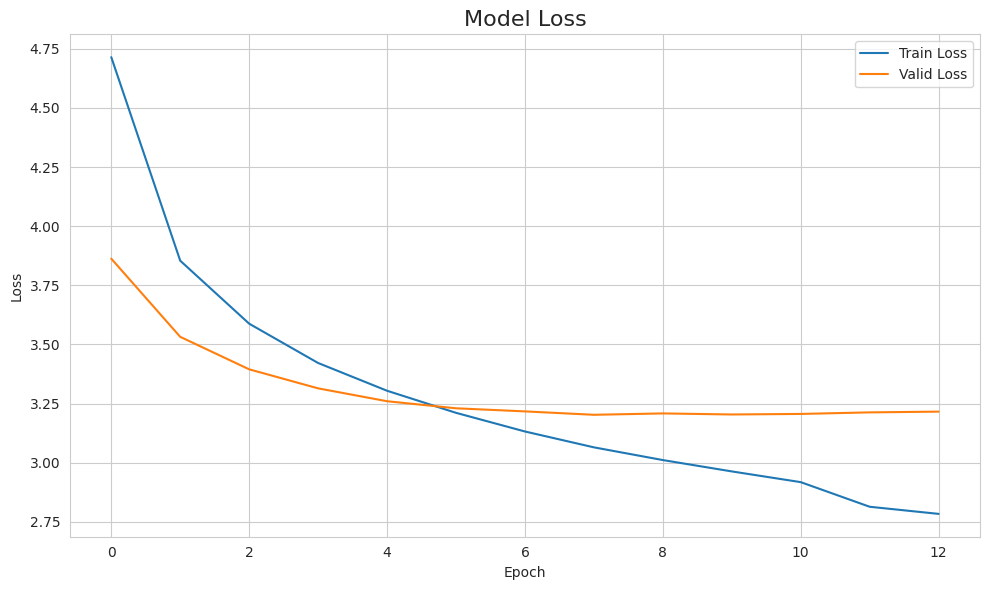

In [22]:
plot_training_history(history)

# Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


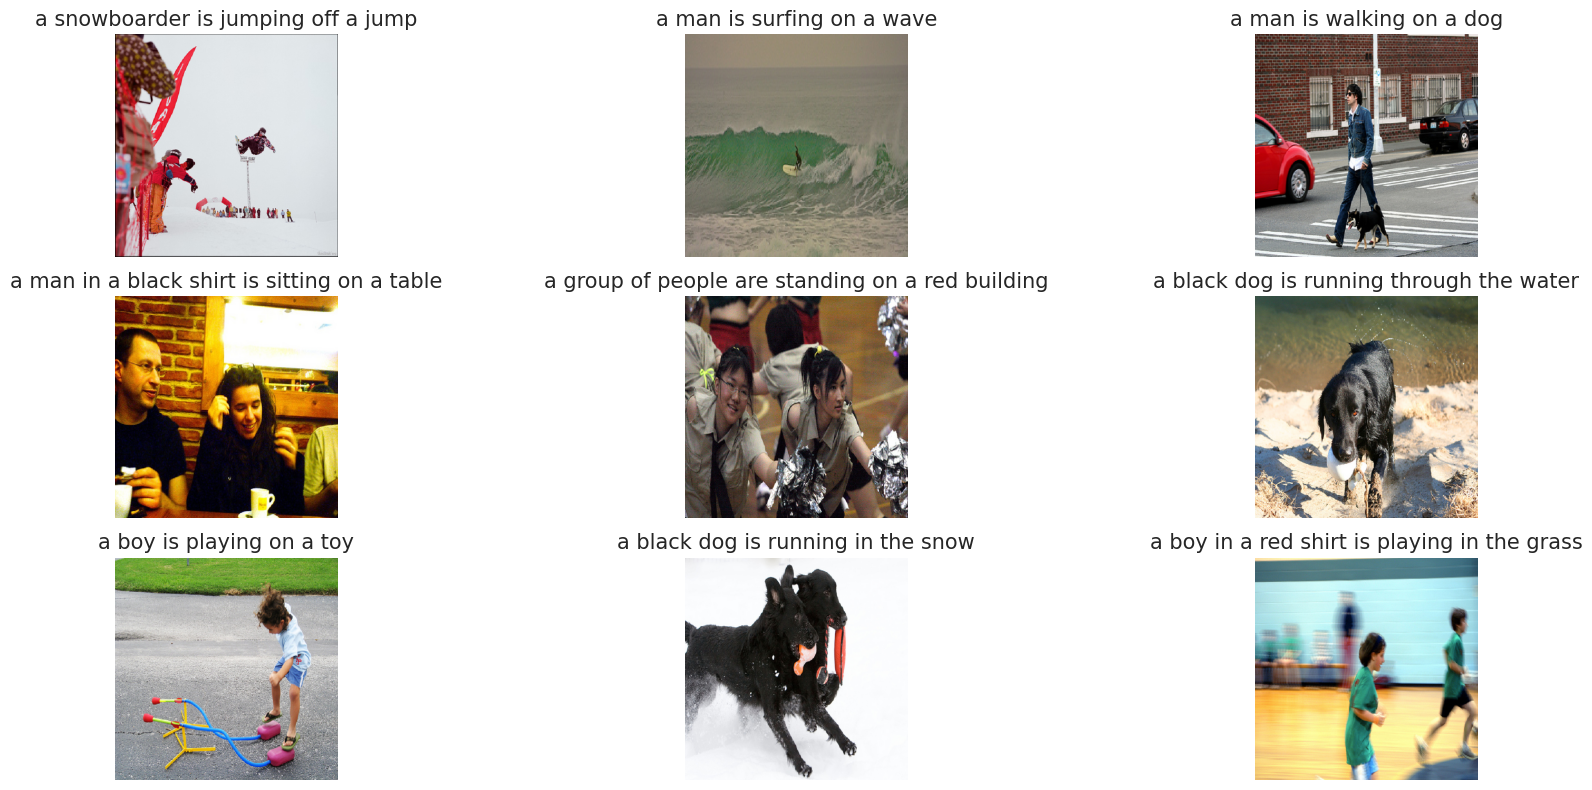

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature.reshape((1, 2560)), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = next((w for w, idx in tokenizer.word_index.items() if idx == yhat), None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return ' '.join(in_text.split()[1:])  # Remove 'startseq'

# Image directory
image_folder = '/kaggle/input/flickr8k/Images'
all_images = os.listdir(image_folder)
selected_images = all_images[10:19]  

# Plot settings
fig, axes = plt.subplots(3, 3, figsize=(20, 8))
axes = axes.flatten()

for i, image_name in enumerate(selected_images):
    img_path = os.path.join(image_folder, image_name)

    # Preprocess image
    img = load_img(img_path, target_size=(600, 600))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Feature extraction
    feature = model.predict(img_array)[0]

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, feature, max_length)

    # Display on subplot
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(caption, fontsize=15)

plt.tight_layout()
plt.show()

### It seems like it's doing well 

### Regrads,
### Mostafa Hamada